In [59]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce 
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots


# Загрузка и обработка данных

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# Исследуем количество пропущеных значений и типы данных в столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [4]:
# Проверяем датасет на дубликаты
data[data.duplicated()].shape[0]

0

In [5]:
# Находим статистические характеристики для каждого признака
data.describe(include='all')

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


In [6]:
# Проверяем распределение значений по типу трудойстройства
data['employment_type'].value_counts(normalize=True)

employment_type
FT    0.968699
PT    0.016474
CT    0.008237
FL    0.006590
Name: proportion, dtype: float64

In [7]:
mask = data['company_location'] == data['employee_residence']
round(data[mask].shape[0] / data.shape[0], 2) 

0.92

In [8]:
# Удаляем неинформативные признаки из датасета
data = data.drop(columns=['Unnamed: 0', 'salary' ,'salary_currency', 'employment_type', 'employee_residence'], axis=1)

* Признак порядкового номера был удален из датасета (Unnamed: 0)
* Признаки запрлата (salary) и валюта (salary_currency) были удалены из датасета по причине присутствия признака приведенной зарплаты к общей валюте (salary_in_usd)
* Признак тип трудоустройства (employment_type) был удален, так как 97% всех значений имели полный рабочий день (FT)
* Признак страна проживания сотрудника (employee_residence) был удален, так как этот признак в 92% случаев совпадает с признаком страны главного офиса работодателя (company_location)

In [9]:
# Находим статистические характеристики для каждого признака для обновленнного датасета
data.describe(include='all')

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
count,607.000000,607,607,607.000000,607.00000,607,607
unique,NaN,4,50,NaN,NaN,50,3
top,NaN,SE,Data Scientist,NaN,NaN,US,M
freq,NaN,280,143,NaN,NaN,355,326
mean,2021.405272,NaN,NaN,112297.869852,70.92257,NaN,NaN
std,0.692133,NaN,NaN,70957.259411,40.70913,NaN,NaN
min,2020.000000,NaN,NaN,2859.000000,0.00000,NaN,NaN
25%,2021.000000,NaN,NaN,62726.000000,50.00000,NaN,NaN
50%,2022.000000,NaN,NaN,101570.000000,100.00000,NaN,NaN
75%,2022.000000,NaN,NaN,150000.000000,100.00000,NaN,NaN


In [10]:
data['remote_ratio'].value_counts()

remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64

* После загрузки и первичной обработки данных получили датасек с 8-ю признаками и 607-ю значениями
* Период, за который отобран датасет, равен 3 годам (2020-2022)
* Наиболее распространненый уровень квалификации - Senior-level/Expert
* В US находится более половины сотрудников (employee_residence) и головных офисов (company_location)
* Больше половины сотрудников работают удаленно
* Минимальная зарплата - 2859 долларов, максимальная зарплата - 600000 долларов, средняя запрлата - 112298 долларов


# Разведывательный анализ данных

## Визуальный анализ данных

C:\Users\dyaki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dyaki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


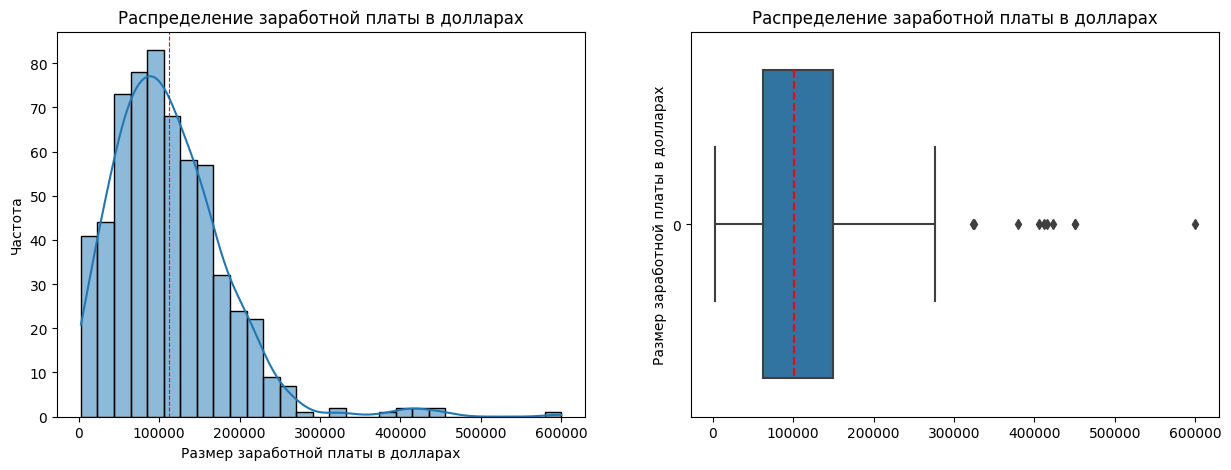

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в долларах', ylabel='Частота')
axes[0].set_title('Распределение заработной платы в долларах')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы в долларах')
axes[1].set_title('Распределение заработной платы в долларах')

plt.show()

In [12]:
fig = px.box(
    data,
    x="salary_in_usd", 
    y="experience_level",
    title='Распределение зарплаты от должности',
    orientation='h'
);
fig.show()

In [13]:
fig = px.box(
    data,
    x="salary_in_usd", 
    y="remote_ratio",
    title='Распределение зарплаты от объема работ выполняемых удаленно',
    orientation='h',
);
fig.show()

In [14]:
fig = px.imshow(
    pd.crosstab(index=data['remote_ratio'], columns=data['experience_level']),
    width=1000,
    height=600, 
    title='Распределение вакансий по должности и количеству выполняемой работы удаленно',
    labels=dict(x="Должность", y="Процент удаленной работы", color="Количество вакансий"),
    y=['0', '50', '100'],
    text_auto=True)
fig.show()

In [15]:
fig = px.box(
    data,
    x="salary_in_usd", 
    y="company_size",
    title='Распределение зарплаты от масштаба компании',
    orientation='h',
);
fig.show()

In [16]:
fig = px.imshow(
    pd.crosstab(index=data['company_size'], columns=data['experience_level']),
    width=1000,
    height=600, 
    title='Распределение вакансий по должности и размеру компаний',
    labels=dict(x="Должность", y="Размер компании", color="Количество вакансий"),
    text_auto=True)
fig.show()

In [17]:
# Код для 10 наиболее часто встречающихся стран в признаке company_location
top_frequency_country = data['company_location'].value_counts().nlargest(10).index
data['company_location'] = data['company_location'].apply(lambda x: x if x in top_frequency_country else 'other')


In [18]:
fig = px.box(
    data,
    height=800,
    x="salary_in_usd", 
    y="company_location",
    title='Распределение зарплаты от страны размещения главного офиса компании',
    orientation='h',
);
fig.show()

In [19]:
fig = px.box(
    data,
    x="salary_in_usd", 
    y="work_year",
    title='Распределение зарплаты от года, в котором была выплачена зарплата',
    orientation='h',
);
fig.show()

In [20]:
fig = px.imshow(
    pd.crosstab(index=data['work_year'], columns=data['experience_level']),
    width=1000,
    height=600, 
    title='Распределение вакансий по должности и году, в котором была выплачена зарплата',
    labels=dict(x="Должность", y="Год", color="Количество вакансий"),
    y=['2020','2021','2022'],
    text_auto=True)
fig.show()

In [21]:
# Код для 10 наиболее часто встречающихся наименований работы job_title
top_frequency_job = data['job_title'].value_counts().nlargest(10).index
data['new_job_title'] = data['job_title'].apply(lambda x: x if x in top_frequency_job else 'other')

In [22]:
fig = px.box(
    data,
    height=800,
    x="salary_in_usd", 
    y="new_job_title",
    title='Распределение зарплаты от роли, в которой соискатель работал в течении года',
    orientation='h',
);
fig.show()

In [23]:
fig = px.box(
    data[data['job_title'] == 'Data Scientist'],
    x="salary_in_usd", 
    y="work_year",
    title='Распределение зарплаты от года, в котором была выплачена зарплата к вакансиям Data Scientist',
    orientation='h',
);
fig.show()

In [24]:
mask1 = data['job_title'] == 'Data Engineer'
mask2 = data['job_title'] == 'Data Scientist'
mask3 = data['work_year'] == 2022
fig = px.box(
    data[(mask1 | mask2) & mask3],
    x="salary_in_usd", 
    y="job_title",
    title='Распределение зарплаты для Data Engineer и Data Scientist в 2022 году',
    orientation='h',
);
fig.show()

In [25]:
mask = data['job_title'] == 'Data Scientist'
fig = px.box(
    data[mask],
    x="salary_in_usd", 
    y="company_size",
    title='Распределение зарплаты от года, в котором была выплачена зарплата',
    orientation='h',
);
fig.show()

In [26]:
fig = px.imshow(
    pd.crosstab(index=data['company_size'], columns=data['new_job_title']),
    width=1000,
    height=600, 
    title='Распределение вакансий по роли, которую выполнял соискатель последний год и размеру компании',
    labels=dict(x="Роль", y="Размер компании", color="Количество вакансий"),
    text_auto=True)
fig.show()

## Выводы по визуальному анализу данных
* Распределение заработной платы не является нормальным
* Заработная плата зависит от занимаемой должности, чем выше должность, тем выше заработная плата
* Наименьшее распределение заработной платы у тех, кто выполняет 50% работы удаленно, кто выполняет 50% работы удаленно больший процент начинающих, соответственно количество выполняемой работы удаленно не влияет на заработную плату
* Наименьшее распределение заработной платы в компаниях размера S, в этих компаниях больший процент начинающих, соответственно размер компании не влияет на заработную плату
* Наибольшее распределение заработной платы в компаниях с головным офисом в US
* Заработная плата растем от года, к котором была выплачена, но с годом растет и количество более высших должностей, соотвественно для уточнения влияния года к заработной плате необходимы дополнительные исследования
* Наибольшую заработную плату получают те, кто выполняют роли Data Architect, Data Science Manager, Principal Data Scientist, Machine Learning Scientist
* У специалистов Data Scientist наблюдается ежегодный рост заработной платы
* В 2022 году заработная плата Data Scientist превышала заработную плату Data Engineer
* У специалистов Data Scientist наибольшая заработная плата в средних компаниях
* Наибольшее количество специалистов Data Scientist и Data Engineer в средних компаниях

### На заработную плату влияют: занимаемая должность, выполняемая роль, страна головного офиса компании.

## Статистический  анализ данных

In [27]:
# задаём уровень значимости для статистических тестов
alpha = 0.05 

In [28]:
# Исследуем количество уникальных значений в каждом столбце
data.nunique()

work_year             3
experience_level      4
job_title            50
salary_in_usd       369
remote_ratio          3
company_location     11
company_size          3
new_job_title        11
dtype: int64

In [29]:
# Кодируем порядковые признаки с помощью функции OrdinalEncoder
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'work_year',
	'mapping': {2020: 1, 2021: 2, 2022: 3}}, 
    {'col': 'experience_level',
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}},
    {'col': 'company_size',
	'mapping': {'S': 1, 'M': 2, 'L': 3}}
    ])
data_bin = ord_encoder.fit_transform(data[['work_year', 'experience_level', 'company_size']])
data = data.drop(columns=['work_year', 'experience_level', 'company_size'], axis=1) # Удаляем исходные порядковые признаки
data = pd.concat([data, data_bin], axis=1) # Добавляем полученные порядковые признаки к датафрейму

In [30]:
data['company_location'].value_counts()

company_location
US       355
other     73
GB        47
CA        30
DE        28
IN        24
FR        15
ES        14
GR        11
JP         6
NL         4
Name: count, dtype: int64

In [31]:
data['job_title'].value_counts()

job_title
Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                  

In [32]:
data['remote_ratio'].value_counts()

remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64

In [33]:
# Закодируем категориальные признаки с помощью функции OneHotEncoder
encoder = ce.OneHotEncoder(cols=['remote_ratio'], use_cat_names=True) # указываем столбцы для кодирования
type_bin = encoder.fit_transform(data[['remote_ratio']])
data = pd.concat([data, type_bin], axis=1)

In [34]:
# Создам категориальный признак по стране компании (company_location)
data['is_US'] = data['company_location'].apply(lambda x: 1 if x == 'US' else 0)

In [35]:
# Создам категориальный признак по роли (job_title)
data['is_data_scientist'] = data['job_title'].apply(lambda x: 1 if x == 'Data Scientist' else 0)
data['is_data_engineer'] = data['job_title'].apply(lambda x: 1 if x == 'Data Engineer' else 0)
data['is_data_analyst'] = data['job_title'].apply(lambda x: 1 if x == 'Data Analyst' else 0)

In [36]:
# Удаляем исходные категориальные признаки
data = data.drop(columns=['remote_ratio', 'job_title' , 'new_job_title', 'company_location'], axis=1) 

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   salary_in_usd       607 non-null    int64
 1   work_year           607 non-null    int32
 2   experience_level    607 non-null    int32
 3   company_size        607 non-null    int32
 4   remote_ratio_0.0    607 non-null    int64
 5   remote_ratio_50.0   607 non-null    int64
 6   remote_ratio_100.0  607 non-null    int64
 7   is_US               607 non-null    int64
 8   is_data_scientist   607 non-null    int64
 9   is_data_engineer    607 non-null    int64
 10  is_data_analyst     607 non-null    int64
dtypes: int32(3), int64(8)
memory usage: 45.2 KB


In [38]:
# Нормализуем признак заработной платы (salary_in_usd) с помощью нормализатора RobustScaler
r_scaler = preprocessing.RobustScaler()
# Кодируем исходный датасет
df_r = r_scaler.fit_transform(data)
# Преобразуем промежуточный датасет в полноценный датафрейм
df_r = pd.DataFrame(df_r, columns=data.columns)
# Заменяем признак заработной платы (salary_in_usd) на нормализованный
data['salary_in_usd'] = df_r['salary_in_usd']

In [39]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Сравним 2022, 2021 и 2020 года парами.

*3 нулевые гипотезы*: $$ H_0 : μ_1 <= μ_2 $$
$$ H_0 : μ_2 <= μ_3 $$
$$ H_0 : μ_1 <= μ_3, $$

где $μ_1$ - запрлата за 2022 год, $μ_2$ - запрлата за 2021 год, $μ_3$ - запрлата за 2020 год.

*3 альтернативные гипотезы*: $$ H_0 : μ_1 > μ_2 $$
$$ H_0 : μ_2 > μ_3 $$
$$ H_0 : μ_1 > μ_3, $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [40]:
# значения зарплат Data Scientist по годам
year_2022 = data.loc[(data['work_year']==3) & (data['is_data_scientist']==1), 'salary_in_usd']
year_2021 = data.loc[(data['work_year']==2) & (data['is_data_scientist']==1), 'salary_in_usd']
year_2020 = data.loc[(data['work_year']==1) & (data['is_data_scientist']==1), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2022 года:')
result = stats.shapiro(year_2022)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(year_2021)
decision_normality(result[1])

print('Для 2020 года:')
result = stats.shapiro(year_2020)
decision_normality(result[1])


Для 2022 года:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2021 года:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для сравнения 2022 и 2021 года используем двухвыборочный t-критерий, для сравнений 2020 с 2022 и 2021 используем критерий Манна-Уитни.

In [41]:
# проводим тест Левена на равенство дисперсий
result = stats.levene(year_2022, year_2021)
p = result[1]
print('p-value = {:.3f}'.format(p))
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [42]:
_, p = stats.ttest_ind(year_2022, year_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [43]:
# проводим тест
_, p = stats.mannwhitneyu(year_2021, year_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [44]:
# проводим тест
_, p = stats.mannwhitneyu(year_2022, year_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата в 2022 году больше, чем в 2021 и 2020, но нет оснований утверждать, что зарплата в 2021 году больше, чем в 2020.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Проверим зарплаты Data Scientist и Data Engineer в 2022 году на больше, меньше и равенство.

*3 нулевые гипотезы*: $$ H_0 : μ_1 = μ_2 $$
$$ H_0 : μ_2 <= μ_1 $$
$$ H_0 : μ_1 <= μ_2, $$

где $μ_1$ - запрлата Data Scientist за 2022 год, $μ_2$ - запрлата Data Engineer за 2021 год.

*3 альтернативные гипотезы*: $$ H_0 : μ_1 \neq μ_2 $$
$$ H_0 : μ_2 > μ_1 $$
$$ H_0 : μ_1 > μ_2, $$

In [45]:
# значения зарплат у Data Scientist и Data Engineer в 2022 году
is_data_scientist = data.loc[(data['is_data_scientist']==1) & (data['work_year']==3), 'salary_in_usd']
is_data_engineer = data.loc[(data['is_data_engineer']==1) & (data['work_year']==3), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(is_data_scientist)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(is_data_engineer)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [46]:
# проводим тест
_, p = stats.mannwhitneyu(is_data_scientist, is_data_engineer)
decision_hypothesis(p)

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [47]:
# проводим тест
_, p = stats.mannwhitneyu(is_data_scientist, is_data_engineer, alternative='less')
decision_hypothesis(p)

p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [48]:
# проводим тест
_, p = stats.mannwhitneyu(is_data_scientist, is_data_engineer, alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что есть разница между зарплатами Data Scientist и Data Engineer в 2022 году

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Проверим зарплаты Data Scientist в небольших, средних и крупных компаниях на больше, меньше и равенство.

*10 нулевых гипотез*: $$ H_0 : μ_1 = μ_2 = μ_3 $$
$$ H_0 : μ_1 = μ_3 $$
$$ H_0 : μ_2 = μ_3 $$
$$ H_0 : μ_1 = μ_2 $$
$$ H_0 : μ_2 <= μ_1 $$
$$ H_0 : μ_1 <= μ_2 $$
$$ H_0 : μ_3 <= μ_1 $$
$$ H_0 : μ_1 <= μ_3 $$
$$ H_0 : μ_3 <= μ_2 $$
$$ H_0 : μ_2 <= μ_3, $$

где $μ_1$ - запрлата Data Engineer в крупных компаниях, $μ_2$ - запрлата Data Engineer в средних компаниях, $μ_3$ - запрлата Data Engineer в небольших компаниях.

*10 альтернативных гипотез*: $$ H_0 : μ_1 \neq μ_2 \neq μ_3 $$
$$ H_0 : μ_1 \neq μ_3 $$
$$ H_0 : μ_2 \neq μ_3 $$
$$ H_0 : μ_1 \neq μ_2 $$
$$ H_0 : μ_2 > μ_1 $$
$$ H_0 : μ_1 > μ_2 $$
$$ H_0 : μ_3 > μ_1 $$
$$ H_0 : μ_1 > μ_3 $$
$$ H_0 : μ_3 > μ_2 $$
$$ H_0 : μ_2 > μ_3 $$

In [49]:
# значения зарплат Data Scientist по размерам компаний
company_size_S = data.loc[(data['company_size']==1) & (data['is_data_scientist']==1), 'salary_in_usd']
company_size_M = data.loc[(data['company_size']==2) & (data['is_data_scientist']==1), 'salary_in_usd']
company_size_L = data.loc[(data['company_size']==3) & (data['is_data_scientist']==1), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для небольшой компании:')
result = stats.shapiro(company_size_S)
decision_normality(result[1])

print('Для средней компании:')
result = stats.shapiro(company_size_M)
decision_normality(result[1])

print('Для крупной компании:')
result = stats.shapiro(company_size_L)
decision_normality(result[1])

Для небольшой компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средней компании:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для сравнения трех значений одновременно используем критерий Краскера-Уоллиса, для сравнения значений средней и небольшой компаний используем двухвыборочный t-критерий, для остальных сравнений используем критерий Манна-Уитни.

In [50]:
# проводим тест с критерием Краскера-Уоллиса
_, p = stats.kruskal(company_size_L, company_size_M, company_size_S)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [51]:
# проводим тест Левена на равенство дисперсий
result = stats.levene(company_size_S, company_size_M)
p = result[1]
print('p-value = {:.3f}'.format(p))
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [52]:
# проводим тест с применением двухвыборочного t-критерия
_, p = stats.ttest_ind(company_size_S, company_size_M, alternative='greater', equal_var=False)
decision_hypothesis(p)

_, p = stats.ttest_ind(company_size_M, company_size_S, alternative='greater', equal_var=False)
decision_hypothesis(p)

_, p = stats.ttest_ind(company_size_M, company_size_S, equal_var=False)
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [53]:
# проводим тест с применением критерия Манна-Уитни
_, p = stats.mannwhitneyu(company_size_S, company_size_L)
decision_hypothesis(p)

_, p = stats.mannwhitneyu(company_size_L, company_size_M)
decision_hypothesis(p)

_, p = stats.mannwhitneyu(company_size_L, company_size_M, alternative='greater')
decision_hypothesis(p)

_, p = stats.mannwhitneyu(company_size_L, company_size_S, alternative='greater')
decision_hypothesis(p)

_, p = stats.mannwhitneyu(company_size_M, company_size_L, alternative='greater')
decision_hypothesis(p)

_, p = stats.mannwhitneyu( company_size_S, company_size_L, alternative='greater')
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.011
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.994
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.999
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Зарплаты специалистов Data Scientist в средних компаниях больше, чем в других компаниях, а зарплаты специалистов Data Scientist в крупных компаниях больше, чем в небольших компаниях.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Проверим зарплаты Data Scientist в небольших, средних и крупных компаниях на больше, меньше и равенство.

*2 нулевые гипотезы*:
1. Между наличием должностей Data Scientist и размером компании нет взаимосвязи (признаки независимы)
2. Между наличием должностей Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*2 альтернативные гипотезы*:
1. Между наличием должностей Data Scientist и размером компании есть взаимосвязи (признаки зависимы)
2. Между наличием должностей Data Engineer и размером компании есть взаимосвязи (признаки зависимы).

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

In [54]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['is_data_scientist'], data['company_size'])

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)


p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [55]:
cross_table = pd.crosstab(data['is_data_engineer'], data['company_size'])

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Между наличием должностей Data Engineer и размером компании есть взаимосвязи (признаки зависимы), но нет оснований утверждать, что между наличием должностей Data Scientist и размером компании есть взаимосвязи (признаки независимы).

### Больше ли средняя зарплата специалистов Data Science общей средней зарплаты в 2022 году? 

*Нулевая гипотеза*: $$ H_0 : μ_1 <= μ_2 $$

где $μ_1$ - средняя зарплата Data Science за 2022 год, $μ_2$ - средняя зарплата за 2022 год.

*Альтернативная гипотеза*: $$ H_0 : μ_1 > μ_2 $$


In [56]:
# значения зарплат Data Scientist по годам
salary_mean = data.loc[data['work_year']==3, 'salary_in_usd'].mean()
salary_ds = data.loc[(data['is_data_scientist']==1) & (data['work_year']==3), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для data scientist:')
result = stats.shapiro(salary_ds)
decision_normality(result[1])

Для data scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Используем одновыбочный t-критерий.

In [57]:
_, p = stats.ttest_1samp(salary_ds, popmean=salary_mean, alternative='greater')
decision_hypothesis(p)

p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

В 2022 году средняя зарплата специалистов Data Science больше, чем общая средняя зарплата. 

## Выводы по статистическому анализу данных
* Зарплата в 2022 году больше, чем в 2021 и 2020, но нет оснований утверждать, что зарплата в 2021 году больше, чем в 2020
* Нет оснований утверждать, что есть разница между зарплатами Data Scientist и Data Engineer в 2022 году
* В 2022 году средняя зарплата специалистов Data Science больше, чем общая средняя зарплата 
* Зарплаты специалистов Data Scientist в средних компаниях больше, чем в других компаниях, а зарплаты специалистов Data Scientist в крупных компаниях больше, чем в небольших компаниях
* Между наличием должностей Data Engineer и размером компании есть взаимосвязи (признаки зависимы), но нет оснований утверждать, что между наличием должностей Data Scientist и размером компании есть взаимосвязи (признаки независимы).


## Общие выводы
* Период, за который отобран датасет, равен 3 годам (2020-2022)
* Наиболее распространненый уровень квалификации - Senior-level/Expert
* Минимальная зарплата - 2859 долларов, максимальная зарплата - 600000 долларов, средняя запрлата - 112298 долларов
* Заработная плата зависит от занимаемой должности, чем выше должность, тем выше заработная плата
* Зарплаты специалистов Data Scientist в средних компаниях больше, чем в других компаниях, а зарплаты специалистов Data Scientist в крупных компаниях больше, чем в небольших компаниях
* Наибольшее распределение заработной платы в компаниях с головным офисом в US
* Зарплата в 2022 году больше, чем в 2021 и 2020, но нет оснований утверждать, что зарплата в 2021 году больше, чем в 2020
* Наибольшую заработную плату получают те, кто выполняют роли Data Architect, Data Science Manager, Principal Data Scientist, Machine Learning Scientist
* У специалистов Data Scientist наблюдается ежегодный рост заработной платы
* В 2022 году средняя зарплата специалистов Data Science больше, чем общая средняя зарплата 
* Нет оснований утверждать, что есть разница между зарплатами Data Scientist и Data Engineer в 2022 году
* Между наличием должностей Data Engineer и размером компании есть взаимосвязи (признаки зависимы), но нет оснований утверждать, что между наличием должностей Data Scientist и размером компании есть взаимосвязи (признаки независимы)
* Наибольшее количество специалистов Data Scientist и Data Engineer в средних компаниях.